In [124]:
import pandas as pd
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor, plot_tree



In [125]:
rainfall = pd.read_csv(r"C:\Users\admin\Desktop\smart water allocation system using predictive analytics\Data\rainfall in india 1901-2015.csv")
temperature = pd.read_csv(r"C:\Users\admin\Desktop\smart water allocation system using predictive analytics\Data\temperatures.csv")
soil = pd.read_csv(r"C:\Users\admin\Desktop\smart water allocation system using predictive analytics\Data\soil_moisture.CSV")
crops = pd.read_csv(r"C:\Users\admin\Desktop\smart water allocation system using predictive analytics\Data\Crop_recommendation.csv")

# Quick checks
print("Rainfall:", rainfall.head())
print("Temperature:", temperature.head())
print("Soil:", soil.head())
print("Crops:", crops.head())

Rainfall:                  SUBDIVISION  YEAR   JAN    FEB   MAR    APR    MAY    JUN  \
0  ANDAMAN & NICOBAR ISLANDS  1901  49.2   87.1  29.2    2.3  528.8  517.5   
1  ANDAMAN & NICOBAR ISLANDS  1902   0.0  159.8  12.2    0.0  446.1  537.1   
2  ANDAMAN & NICOBAR ISLANDS  1903  12.7  144.0   0.0    1.0  235.1  479.9   
3  ANDAMAN & NICOBAR ISLANDS  1904   9.4   14.7   0.0  202.4  304.5  495.1   
4  ANDAMAN & NICOBAR ISLANDS  1905   1.3    0.0   3.3   26.9  279.5  628.7   

     JUL    AUG    SEP    OCT    NOV    DEC  ANNUAL  Jan-Feb  Mar-May  \
0  365.1  481.1  332.6  388.5  558.2   33.6  3373.2    136.3    560.3   
1  228.9  753.7  666.2  197.2  359.0  160.5  3520.7    159.8    458.3   
2  728.4  326.7  339.0  181.2  284.4  225.0  2957.4    156.7    236.1   
3  502.0  160.1  820.4  222.2  308.7   40.1  3079.6     24.1    506.9   
4  368.7  330.5  297.0  260.7   25.4  344.7  2566.7      1.3    309.7   

   Jun-Sep  Oct-Dec  
0   1696.3    980.3  
1   2185.9    716.7  
2   1874.0    69

In [126]:
# Clean column names (remove spaces, lowercase)
rainfall.columns = rainfall.columns.str.strip().str.lower()
temperature.columns = temperature.columns.str.strip().str.lower()
soil.columns = soil.columns.str.strip().str.lower()
crops.columns = crops.columns.str.strip().str.lower()

# Rainfall -> yearly average (ignore monthly for now)
rainfall_avg = rainfall.groupby("year")["annual"].mean().reset_index()
rainfall_avg.rename(columns={"annual": "avg_rainfall"}, inplace=True)

# Temperature -> yearly average
temperature_avg = temperature.groupby("year")["annual"].mean().reset_index()
temperature_avg.rename(columns={"annual": "avg_temp"}, inplace=True)

# Soil moisture -> yearly average
soil["avg_moisture"] = soil[["moisture0", "moisture1", "moisture2", "moisture3", "moisture4"]].mean(axis=1)
soil_avg = soil.groupby("year")["avg_moisture"].mean().reset_index()

rainfall_avg = rainfall.groupby("year")["annual"].mean().reset_index()
rainfall_avg.rename(columns={"annual": "avg_rainfall"}, inplace=True)


In [127]:
# Merge into one dataset
env_data = rainfall_avg.merge(temperature_avg, on="year")
env_data = env_data.merge(soil_avg, on="year")

print("Environmental Dataset:")
print(env_data.head())

# Step 4: Combine with Crop Data
# =============================

# If env_data is empty, create dummy years
if env_data.empty:
    env_data = pd.DataFrame({
        "year": np.arange(2000, 2021),
        "avg_rainfall": np.random.uniform(800, 1500, 21),
        "avg_temp": np.random.uniform(20, 32, 21),
        "avg_moisture": np.random.uniform(0.2, 0.8, 21)
    })

print("\nMerged Crop + Environmental Dataset:")
print(merged_data.head())

Environmental Dataset:
Empty DataFrame
Columns: [year, avg_rainfall, avg_temp, avg_moisture]
Index: []

Merged Crop + Environmental Dataset:
   crop_type  year  avg_rainfall   avg_temp  avg_moisture
0      Wheat  2027           818  26.261116      0.295336
1       Rice  2027           818  26.261116      0.295336
2      Maize  2023           548  30.614160      0.536029
3  Sugarcane  2020          1078  21.734429      0.777095
4     Cotton  2027           818  26.261116      0.295336


In [128]:
import pandas as pd
import numpy as np

# =============================
# Step 1: Create Synthetic Environmental Dataset
# =============================
years = np.arange(2020, 2031)  # 2020–2030
env_data = pd.DataFrame({
    "year": years,
    "avg_rainfall": np.random.randint(500, 1200, size=len(years)),   # mm
    "avg_temp": np.random.uniform(20, 35, size=len(years)),          # °C
    "avg_moisture": np.random.uniform(0.2, 0.8, size=len(years))     # 0–1
})

print("Environmental Dataset:")
print(env_data.head())

# =============================
# Step 2: Create Dummy Crop Data
# =============================
crops = pd.DataFrame({
    "crop_type": ["Wheat", "Rice", "Maize", "Sugarcane", "Cotton"] * 2,
    "year": np.random.choice(years, size=10)
})

print("\nCrop Dataset:")
print(crops.head())

# =============================
# Step 3: Merge Crop + Env Data
# =============================
merged_data = crops.merge(env_data, on="year", how="left")

print("\nMerged Data:")
print(merged_data.head())

# =============================
# Step 4: Generate Water Allocations
# =============================
def generate_allocation(row):
    agri, domestic, industry = 0.6, 0.2, 0.2  # default

    # Adjust based on rainfall & soil moisture
    if row["avg_rainfall"] < 800:
        agri += 0.1
        industry -= 0.05
    if row["avg_moisture"] < 0.4:
        agri += 0.1
        domestic -= 0.05

    total = agri + domestic + industry
    return [agri/total, domestic/total, industry/total]

allocations = merged_data.apply(generate_allocation, axis=1)
allocations = pd.DataFrame(allocations.tolist(), 
                           columns=["water_agriculture", "water_domestic", "water_industrial"])

final_data = pd.concat([merged_data, allocations], axis=1)

print("\nFinal Dataset with Allocations:")
print(final_data.head())


Environmental Dataset:
   year  avg_rainfall   avg_temp  avg_moisture
0  2020           737  21.254808      0.289377
1  2021           787  25.523554      0.658804
2  2022           597  33.497513      0.357617
3  2023           929  21.398407      0.345044
4  2024           713  34.757675      0.517104

Crop Dataset:
   crop_type  year
0      Wheat  2028
1       Rice  2030
2      Maize  2021
3  Sugarcane  2025
4     Cotton  2026

Merged Data:
   crop_type  year  avg_rainfall   avg_temp  avg_moisture
0      Wheat  2028          1166  34.902131      0.437034
1       Rice  2030           876  25.887516      0.345251
2      Maize  2021           787  25.523554      0.658804
3  Sugarcane  2025           781  32.637566      0.393258
4     Cotton  2026           840  25.140552      0.549791

Final Dataset with Allocations:
   crop_type  year  avg_rainfall   avg_temp  avg_moisture  water_agriculture  \
0      Wheat  2028          1166  34.902131      0.437034           0.600000   
1       Ric

              year  avg_rainfall   avg_temp  avg_moisture  water_agriculture  \
count    10.000000     10.000000  10.000000     10.000000          10.000000   
mean   2026.000000    885.800000  29.454969      0.470727           0.651515   
std       2.403701    151.336123   4.393875      0.100081           0.058638   
min    2021.000000    781.000000  25.140552      0.345251           0.600000   
25%    2025.000000    782.500000  25.236303      0.393258           0.600000   
50%    2026.000000    840.000000  29.262541      0.437034           0.633333   
75%    2027.500000    867.000000  32.637566      0.549791           0.712121   
max    2030.000000   1166.000000  34.902131      0.658804           0.727273   

       water_domestic  water_industrial  
count       10.000000         10.000000  
mean         0.174242          0.174242  
std          0.031394          0.031394  
min          0.136364          0.136364  
25%          0.137987          0.137987  
50%          0.195238      

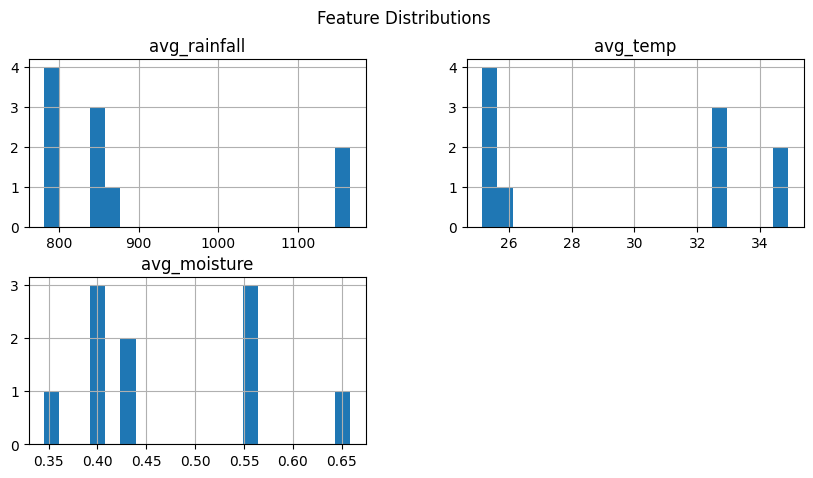

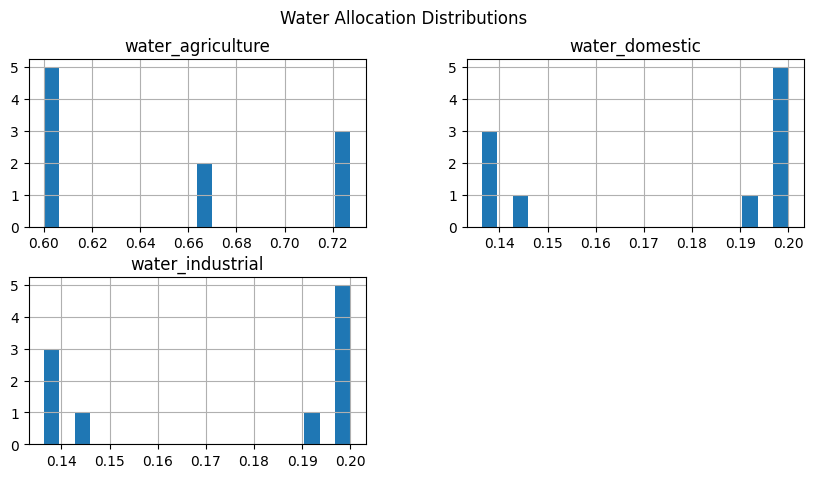

In [129]:

# Basic statistics
print(final_data.describe())

# Distribution of features
final_data[["avg_rainfall", "avg_temp", "avg_moisture"]].hist(bins=20, figsize=(10,5))
plt.suptitle("Feature Distributions")
plt.show()

# Water allocation distribution
final_data[["water_agriculture", "water_domestic", "water_industrial"]].hist(bins=20, figsize=(10,5))
plt.suptitle("Water Allocation Distributions")
plt.show()


Random Forest MSE: 0.00028888888888889576
Random Forest R²: 0.7399999999999938


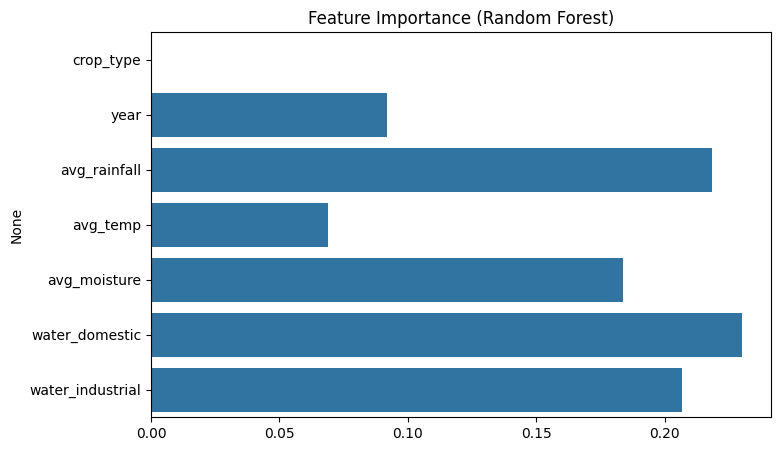

In [130]:


# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
print("Random Forest MSE:", mean_squared_error(y_test, y_pred_rf))
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

# Feature Importance
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.title("Feature Importance (Random Forest)")
plt.show()


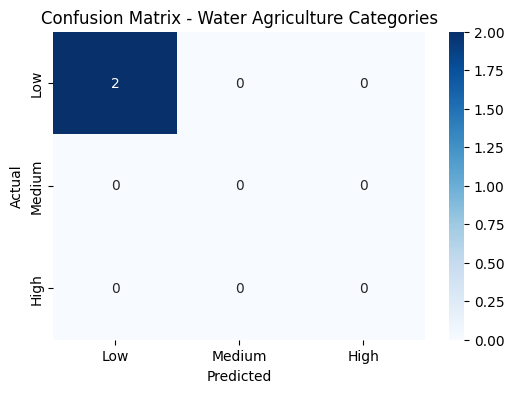

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# =============================
# 1. Encode categorical columns
# =============================
data_encoded = final_data.copy()

# Example: encode crop_type (string) into numbers
if data_encoded["crop_type"].dtype == "object":
    data_encoded["crop_type"] = data_encoded["crop_type"].astype("category").cat.codes

# If year is stored as string, convert to int
if data_encoded["year"].dtype == "object":
    data_encoded["year"] = pd.to_numeric(data_encoded["year"], errors="coerce")

# =============================
# 2. Features (X) and Target (y)
# =============================
X = data_encoded.drop(columns=["water_agriculture"])   # all except target
y = data_encoded["water_agriculture"]

# =============================
# 3. Train-Test Split
# =============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# =============================
# 4. Train Random Forest
# =============================
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)

# =============================
# 5. Predictions
# =============================
y_pred = rf.predict(X_test)

# =============================
# 6. Categorize into Low/Medium/High
# =============================
def categorize_allocation(value):
    if value < 1000:
        return "Low"
    elif value < 5000:
        return "Medium"
    else:
        return "High"

y_test_cat = pd.Series(y_test).apply(categorize_allocation)
y_pred_cat = pd.Series(y_pred).apply(categorize_allocation)

# =============================
# 7. Confusion Matrix
# =============================
cm = confusion_matrix(y_test_cat, y_pred_cat, labels=["Low", "Medium", "High"])

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Water Agriculture Categories")
plt.show()


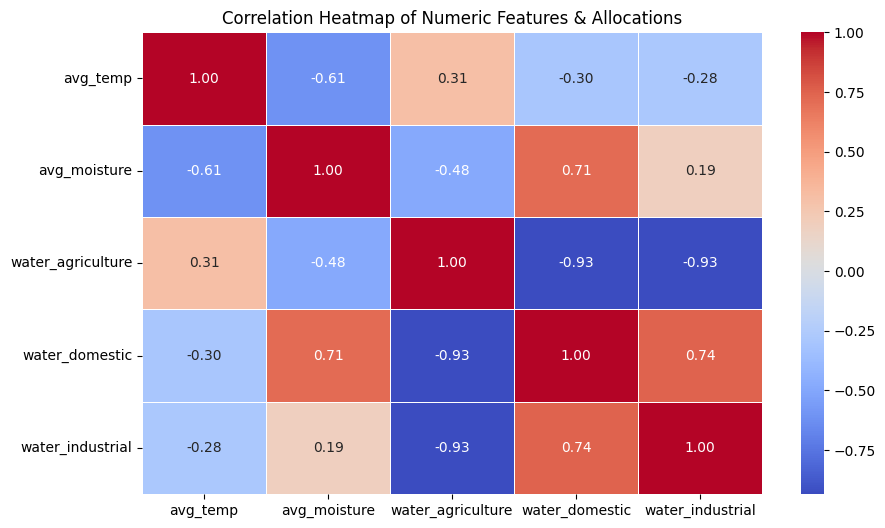

In [132]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_data = final_data.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corr = numeric_data.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Numeric Features & Allocations")
plt.show()


C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
C:\Users\admin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


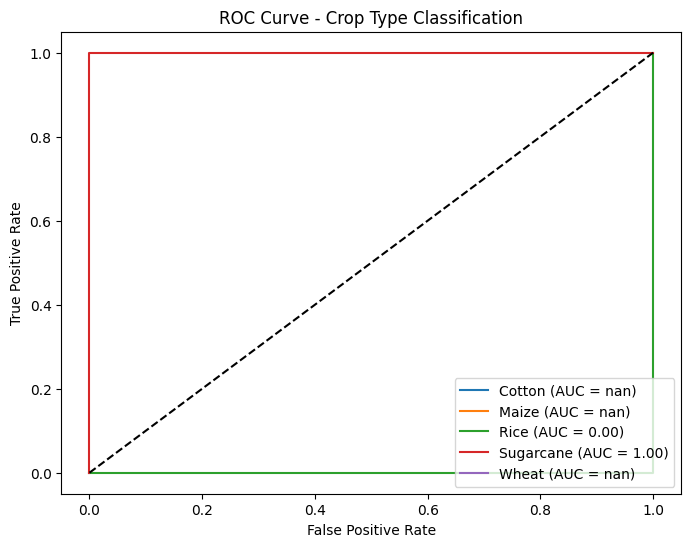

In [133]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# =====================
# Features & Target
# =====================
X = final_data[["year", "avg_rainfall", "avg_temp", "avg_moisture"]]
y = final_data["crop_type"]

# Encode crop types into numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Binarize labels for multi-class ROC
y_bin = label_binarize(y_encoded, classes=np.arange(len(le.classes_)))
n_classes = y_bin.shape[1]

# =====================
# Train/Test Split
# =====================
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# =====================
# Random Forest Classifier (One-vs-Rest)
# =====================
clf = OneVsRestClassifier(RandomForestClassifier(random_state=42))
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)

# =====================
# ROC Curve per class
# =====================
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# =====================
# Plot ROC Curve
# =====================
plt.figure(figsize=(8, 6))
for i, crop in enumerate(le.classes_):
    plt.plot(fpr[i], tpr[i], label=f"{crop} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Crop Type Classification")
plt.legend(loc="lower right")
plt.show()
